<a href="https://colab.research.google.com/github/subhendu1F/numberPlanteEnhancement/blob/main/Srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [2]:
#Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])


In [3]:
def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model


In [4]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [5]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

In [6]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)



In [7]:
#VGG19
#We need VGG19 for the feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer.
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

In [8]:
def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


In [9]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [10]:
import os
import time
import random
import glob
import numpy as np

import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
def load(path,shape):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, shape)
    return img


def get_data(path_hr, path_lr):
    HR_images = []
    LR_images = []

    hr_files = sorted(glob.glob(os.path.join(path_hr, '*')))
    lr_files = sorted(glob.glob(os.path.join(path_lr, '*')))

    for hr_path, lr_path in zip(hr_files, lr_files):
        HR_images.append(load(hr_path, (256, 256)))
        LR_images.append(load(lr_path, (64, 64)))

    HR_images = np.array(HR_images) / 255.0
    LR_images = np.array(LR_images) / 255.0

    return HR_images, LR_images


In [12]:
hr_images, lr_images = get_data('/content/drive/MyDrive/Ml/Car_test/HR', '/content/drive/MyDrive/Ml/Car_test/LR')
hr_images.shape, lr_images.shape

((284, 256, 256, 3), (284, 64, 64, 3))

In [13]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)


In [14]:
lr_train.shape,hr_train.shape,lr_test.shape,hr_test.shape

((190, 64, 64, 3), (190, 256, 256, 3), (94, 64, 64, 3), (94, 256, 256, 3))

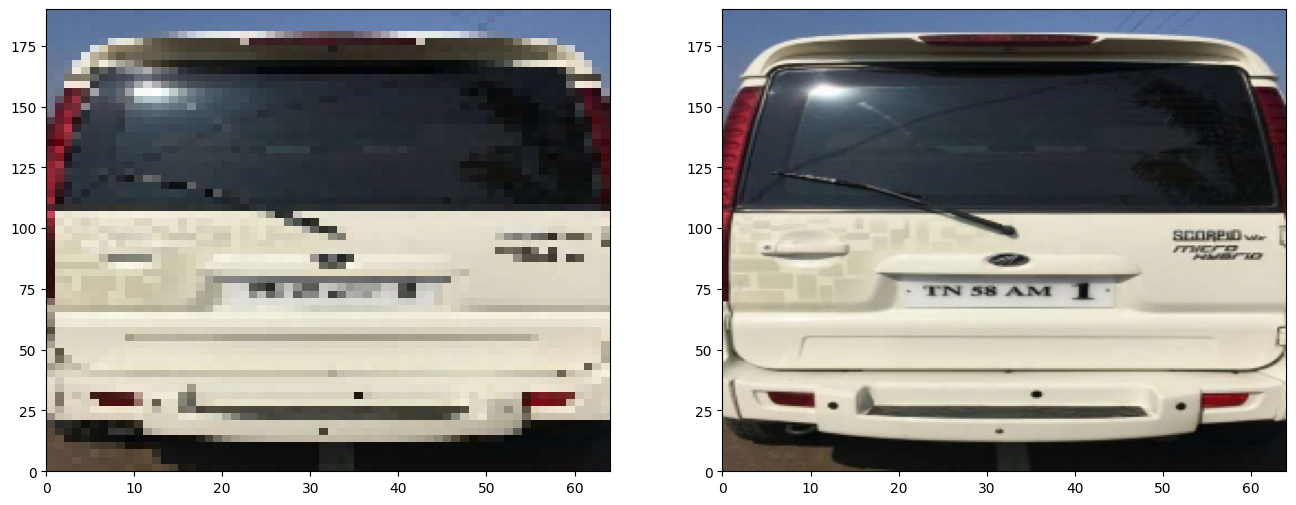

In [15]:

f, ax = plt.subplots(1, 2, figsize=(16, 6))

# Assuming LR_train and HR_train have the same dimensions
extent = [0, lr_train.shape[1], 0, lr_train.shape[0]]

# Display the first image (LR_train[save_ind])
ax[0].imshow(lr_train[120], aspect='auto', extent=extent)

# Display the second image (HR_train[save_ind])
ax[1].imshow(hr_train[120], aspect='auto', extent=extent)

plt.show()


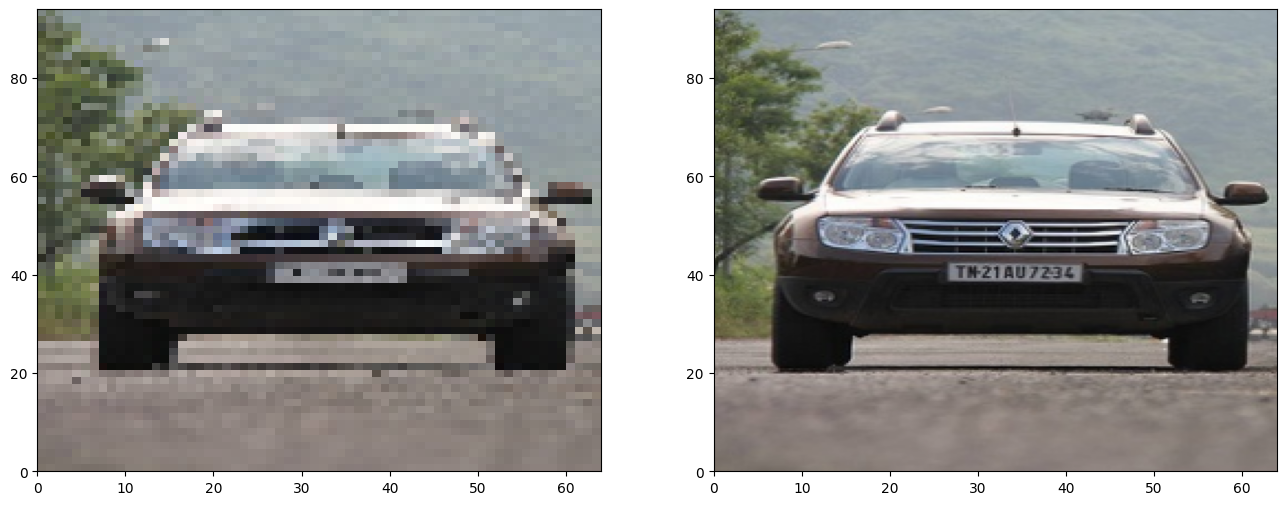

In [16]:

f, ax = plt.subplots(1, 2, figsize=(16, 6))

# Assuming LR_train and HR_train have the same dimensions
extent = [0, lr_test.shape[1], 0, lr_test.shape[0]]

# Display the first image (LR_train[save_ind])
ax[0].imshow(lr_test[20], aspect='auto', extent=extent)

# Display the second image (HR_train[save_ind])
ax[1].imshow(hr_test[20], aspect='auto', extent=extent)

plt.show()


In [17]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [18]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 64, 64, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

In [19]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_33 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                           

In [20]:
vgg = build_vgg((256,256,3))
print(vgg.summary())
vgg.trainable = False

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                            

In [21]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [22]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 256, 256, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    1389125   ['model[0][0]']               
                                                          77                                

In [23]:
checkpoint_dir = "/content/drive/MyDrive/Ml/checkpoint_dir"


In [72]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training.
batch_size = 16
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])


epochs = 50
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        weights_path = os.path.join(checkpoint_dir, f"gen_weights_enew2_{e + 1}.h5")
        generator.save_weights(weights_path)

#   # To load the weights back:
# weights_to_load = os.path.join(checkpoint_dir, "gen_weights_e_50.h5")  # Adjust the epoch number accordingly
# generator.load_weights(weights_to_load)


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1/11 [00:03<00:39,  3.96s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:06<00:27,  3.10s/it]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 3/11 [00:08<00:22,  2.83s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4/11 [00:12<00:22,  3.16s/it]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 5/11 [00:15<00:18,  3.06s/it]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 6/11 [00:18<00:14,  2.98s/it]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.85s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.75s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.67s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.63s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


epoch: 1 g_loss: 3.4410129460421475 d_loss: [1.70318328 0.49715909]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 1/11 [00:03<00:37,  3.77s/it]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2/11 [00:06<00:28,  3.17s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3/11 [00:09<00:22,  2.87s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:11<00:18,  2.71s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.63s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 6/11 [00:16<00:12,  2.59s/it]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.97s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.83s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.73s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.66s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 11/11 [00:30<00:00,  2.75s/it]


epoch: 2 g_loss: 2.787045023658059 d_loss: [1.04818002 0.40056818]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 1/11 [00:02<00:28,  2.82s/it]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2/11 [00:06<00:30,  3.42s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 3/11 [00:09<00:23,  2.99s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.79s/it]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.69s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 6/11 [00:17<00:15,  3.02s/it]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.98s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.83s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.73s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.66s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


epoch: 3 g_loss: 2.590287988836115 d_loss: [0.90290481 0.36931818]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 1/11 [00:03<00:37,  3.76s/it]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 2/11 [00:06<00:28,  3.22s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3/11 [00:09<00:23,  2.89s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.73s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:14<00:15,  2.65s/it]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 6/11 [00:17<00:15,  3.02s/it]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.92s/it]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.79s/it]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.69s/it]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.63s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:31<00:00,  2.88s/it]


epoch: 4 g_loss: 2.467317732897672 d_loss: [0.94854773 0.39488636]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 1/11 [00:02<00:26,  2.66s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.64s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.60s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.57s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5/11 [00:12<00:15,  2.55s/it]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6/11 [00:16<00:15,  3.01s/it]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.93s/it]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.80s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.72s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.67s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


epoch: 5 g_loss: 2.393017292022705 d_loss: [0.87753083 0.42329545]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 1/11 [00:02<00:27,  2.79s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.63s/it]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.60s/it]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.56s/it]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.62s/it]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 6/11 [00:15<00:13,  2.68s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7/11 [00:18<00:10,  2.68s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.63s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:23<00:05,  2.60s/it]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 10/11 [00:26<00:02,  2.58s/it]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 11/11 [00:29<00:00,  2.72s/it]


epoch: 6 g_loss: 2.3405046463012695 d_loss: [0.85388997 0.38068182]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1/11 [00:02<00:27,  2.76s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.62s/it]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.58s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.55s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.96s/it]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 6/11 [00:17<00:16,  3.29s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7/11 [00:20<00:12,  3.07s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.89s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.77s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 10/11 [00:29<00:03,  3.05s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 11/11 [00:33<00:00,  3.01s/it]


epoch: 7 g_loss: 2.2983402122150767 d_loss: [0.75422433 0.41761364]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.51s/it]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.51s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.96s/it]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.92s/it]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.79s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.70s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.65s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.97s/it]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 10/11 [00:29<00:03,  3.29s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:32<00:00,  3.00s/it]


epoch: 8 g_loss: 2.2655523256822065 d_loss: [0.7505445  0.36647727]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.50s/it]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.52s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 3/11 [00:08<00:25,  3.13s/it]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.98s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.82s/it]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.73s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.66s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.98s/it]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.93s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.80s/it]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


epoch: 9 g_loss: 2.2369217655875464 d_loss: [0.7291401  0.42613636]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.54s/it]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.54s/it]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3/11 [00:09<00:25,  3.17s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.96s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.84s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.73s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.67s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 8/11 [00:23<00:09,  3.06s/it]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.95s/it]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.82s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:30<00:00,  2.82s/it]


epoch: 10 g_loss: 2.2129248922521416 d_loss: [0.72395516 0.36079545]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.52s/it]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 2/11 [00:06<00:29,  3.30s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 3/11 [00:09<00:24,  3.03s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.83s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.72s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.66s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.62s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 8/11 [00:23<00:09,  3.04s/it]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.88s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.77s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 11/11 [00:30<00:00,  2.79s/it]


epoch: 11 g_loss: 2.1917789415879683 d_loss: [0.71825538 0.41193182]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 1/11 [00:03<00:36,  3.69s/it]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 2/11 [00:07<00:34,  3.87s/it]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 3/11 [00:10<00:25,  3.25s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 4/11 [00:12<00:20,  2.98s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5/11 [00:15<00:16,  2.81s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 6/11 [00:18<00:15,  3.11s/it]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 7/11 [00:22<00:13,  3.38s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8/11 [00:25<00:09,  3.10s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:27<00:05,  2.91s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:30<00:02,  2.79s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:34<00:00,  3.10s/it]


epoch: 12 g_loss: 2.1726117567582564 d_loss: [0.71314933 0.40909091]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.59s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.57s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.54s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.53s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 5/11 [00:12<00:15,  2.53s/it]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 6/11 [00:15<00:13,  2.63s/it]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 7/11 [00:18<00:10,  2.67s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:20<00:07,  2.63s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9/11 [00:23<00:05,  2.60s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:25<00:02,  2.59s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 11/11 [00:29<00:00,  2.69s/it]


epoch: 13 g_loss: 2.155584357001565 d_loss: [0.71320237 0.41477273]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1/11 [00:03<00:39,  3.93s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:06<00:27,  3.10s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 3/11 [00:10<00:26,  3.37s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:12<00:21,  3.05s/it]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 5/11 [00:15<00:17,  2.92s/it]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6/11 [00:18<00:14,  2.91s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:21<00:11,  2.85s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.75s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:26<00:05,  2.69s/it]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.67s/it]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 11/11 [00:32<00:00,  2.96s/it]


epoch: 14 g_loss: 2.1400183005766436 d_loss: [0.70922396 0.46306818]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 1/11 [00:02<00:27,  2.74s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.62s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.58s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.56s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 5/11 [00:12<00:15,  2.55s/it]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 6/11 [00:16<00:14,  2.99s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.83s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:21<00:08,  2.73s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.67s/it]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 10/11 [00:28<00:03,  3.09s/it]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 11/11 [00:31<00:00,  2.84s/it]


epoch: 15 g_loss: 2.125713272528215 d_loss: [0.71060227 0.44602273]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1/11 [00:02<00:27,  2.79s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.63s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.57s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.56s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.96s/it]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 6/11 [00:16<00:14,  2.85s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.80s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:21<00:08,  2.70s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.64s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:26<00:02,  2.60s/it]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 11/11 [00:29<00:00,  2.68s/it]


epoch: 16 g_loss: 2.1125050241296943 d_loss: [0.71703382 0.47159091]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1/11 [00:03<00:39,  3.92s/it]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 2/11 [00:06<00:27,  3.10s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3/11 [00:10<00:27,  3.38s/it]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 4/11 [00:12<00:21,  3.04s/it]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 5/11 [00:16<00:19,  3.33s/it]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 6/11 [00:19<00:15,  3.12s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 7/11 [00:21<00:11,  2.92s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:24<00:08,  2.79s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:26<00:05,  2.71s/it]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 10/11 [00:29<00:02,  2.66s/it]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


epoch: 17 g_loss: 2.1002122922377153 d_loss: [0.71835022 0.48863636]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 1/11 [00:02<00:27,  2.77s/it]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.64s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.60s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 4/11 [00:10<00:18,  2.57s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.97s/it]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 6/11 [00:16<00:14,  2.91s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.79s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:21<00:08,  2.71s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.66s/it]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 10/11 [00:28<00:03,  3.01s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


epoch: 18 g_loss: 2.088673634962602 d_loss: [0.72583018 0.48295455]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.57s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.55s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.55s/it]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.56s/it]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.65s/it]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6/11 [00:17<00:15,  3.11s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.92s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.81s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.73s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.69s/it]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 11/11 [00:31<00:00,  2.83s/it]


epoch: 19 g_loss: 2.077788558873263 d_loss: [0.72984295 0.48011364]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.55s/it]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 2/11 [00:06<00:29,  3.22s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 3/11 [00:08<00:23,  2.92s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:12<00:22,  3.22s/it]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 5/11 [00:16<00:20,  3.42s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6/11 [00:18<00:15,  3.11s/it]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 7/11 [00:21<00:11,  2.92s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.79s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:27<00:06,  3.07s/it]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 10/11 [00:31<00:03,  3.29s/it]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 11/11 [00:33<00:00,  3.07s/it]


epoch: 20 g_loss: 2.0676227916370737 d_loss: [0.71856989 0.48863636]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.54s/it]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.53s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 3/11 [00:08<00:25,  3.16s/it]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.95s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.79s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.70s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.64s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.61s/it]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.99s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.87s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 11/11 [00:30<00:00,  2.79s/it]


epoch: 21 g_loss: 2.058009992946278 d_loss: [0.71219844 0.50852273]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.54s/it]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.54s/it]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3/11 [00:07<00:21,  2.63s/it]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 4/11 [00:11<00:21,  3.11s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.89s/it]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.78s/it]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.71s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.65s/it]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 9/11 [00:25<00:06,  3.01s/it]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.88s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


epoch: 22 g_loss: 2.048870010809465 d_loss: [0.71312567 0.48579545]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.55s/it]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3/11 [00:09<00:25,  3.21s/it]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.96s/it]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.81s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.72s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.65s/it]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 8/11 [00:23<00:09,  3.04s/it]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.95s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.82s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 11/11 [00:30<00:00,  2.82s/it]


epoch: 23 g_loss: 2.0400796586816963 d_loss: [0.71205438 0.50284091]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.52s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:06<00:28,  3.22s/it]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 3/11 [00:08<00:23,  2.94s/it]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.80s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:13<00:16,  2.69s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.66s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.61s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 8/11 [00:22<00:09,  3.01s/it]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 9/11 [00:26<00:06,  3.31s/it]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 10/11 [00:29<00:03,  3.06s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 11/11 [00:31<00:00,  2.90s/it]


epoch: 24 g_loss: 2.031713290648027 d_loss: [0.70845161 0.53693182]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 1/11 [00:03<00:37,  3.71s/it]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 2/11 [00:07<00:34,  3.84s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3/11 [00:10<00:25,  3.23s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:12<00:20,  2.99s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 5/11 [00:15<00:16,  2.82s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6/11 [00:18<00:15,  3.12s/it]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 7/11 [00:22<00:13,  3.36s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:25<00:09,  3.09s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:27<00:05,  2.94s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 10/11 [00:30<00:02,  2.81s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 11/11 [00:34<00:00,  3.11s/it]


epoch: 25 g_loss: 2.0236997495998037 d_loss: [0.70358614 0.52272727]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 1/11 [00:02<00:28,  2.83s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.66s/it]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.61s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:10<00:18,  2.57s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.97s/it]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 6/11 [00:16<00:14,  2.93s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.80s/it]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.72s/it]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.66s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.63s/it]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 11/11 [00:29<00:00,  2.71s/it]


epoch: 26 g_loss: 2.016050349582325 d_loss: [0.70117698 0.54261364]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 1/11 [00:03<00:39,  3.93s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:06<00:27,  3.11s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 3/11 [00:09<00:22,  2.85s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.73s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5/11 [00:15<00:18,  3.10s/it]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 6/11 [00:17<00:14,  2.93s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.83s/it]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.74s/it]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.70s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.65s/it]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


epoch: 27 g_loss: 2.0086961551146074 d_loss: [0.69840963 0.55113636]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 1/11 [00:03<00:37,  3.77s/it]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 2/11 [00:06<00:27,  3.05s/it]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 3/11 [00:08<00:22,  2.82s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:11<00:18,  2.71s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.65s/it]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 6/11 [00:18<00:15,  3.15s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.95s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:24<00:09,  3.18s/it]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 9/11 [00:26<00:05,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:30<00:03,  3.22s/it]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 11/11 [00:33<00:00,  3.03s/it]


epoch: 28 g_loss: 2.00174221125516 d_loss: [0.70725028 0.55397727]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.53s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.53s/it]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.53s/it]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 5/11 [00:12<00:15,  2.61s/it]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 6/11 [00:15<00:13,  2.66s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 7/11 [00:18<00:10,  2.62s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 8/11 [00:20<00:07,  2.59s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:23<00:05,  2.58s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 10/11 [00:26<00:02,  2.92s/it]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 11/11 [00:29<00:00,  2.71s/it]


epoch: 29 g_loss: 1.9949218251488425 d_loss: [0.70511306 0.53693182]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.52s/it]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 2/11 [00:05<00:24,  2.67s/it]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3/11 [00:08<00:21,  2.69s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:11<00:21,  3.08s/it]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 5/11 [00:15<00:20,  3.39s/it]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6/11 [00:18<00:15,  3.11s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.92s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.80s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 9/11 [00:26<00:06,  3.08s/it]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 10/11 [00:29<00:03,  3.02s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 11/11 [00:32<00:00,  2.94s/it]


epoch: 30 g_loss: 1.9882915019989014 d_loss: [0.69308477 0.55397727]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.54s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3/11 [00:08<00:24,  3.07s/it]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 4/11 [00:12<00:24,  3.43s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5/11 [00:15<00:18,  3.12s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 6/11 [00:17<00:14,  2.92s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.80s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:24<00:09,  3.09s/it]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 9/11 [00:26<00:05,  2.99s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:29<00:02,  2.85s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 11/11 [00:31<00:00,  2.91s/it]


epoch: 31 g_loss: 1.981786240230907 d_loss: [0.70008755 0.57102273]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.58s/it]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 3/11 [00:09<00:25,  3.16s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.97s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.82s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.72s/it]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.66s/it]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.64s/it]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.68s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.68s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 11/11 [00:29<00:00,  2.72s/it]


epoch: 32 g_loss: 1.9754417050968518 d_loss: [0.71397908 0.59659091]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.53s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3/11 [00:07<00:21,  2.64s/it]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 4/11 [00:10<00:18,  2.68s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.64s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 6/11 [00:15<00:13,  2.60s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 7/11 [00:18<00:10,  2.58s/it]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 8/11 [00:20<00:07,  2.57s/it]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.97s/it]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.88s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 11/11 [00:29<00:00,  2.71s/it]


epoch: 33 g_loss: 1.9693865017457441 d_loss: [0.70818553 0.53977273]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.52s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.52s/it]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 4/11 [00:11<00:21,  3.02s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5/11 [00:13<00:17,  2.84s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.74s/it]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 7/11 [00:18<00:10,  2.68s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.63s/it]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 9/11 [00:25<00:06,  3.04s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.93s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:30<00:00,  2.79s/it]


epoch: 34 g_loss: 1.963584845716303 d_loss: [0.71360922 0.58806818]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.58s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.56s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3/11 [00:08<00:25,  3.16s/it]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 4/11 [00:11<00:21,  3.02s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.85s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.75s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.68s/it]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 8/11 [00:23<00:09,  3.02s/it]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.94s/it]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.82s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 11/11 [00:31<00:00,  2.82s/it]


epoch: 35 g_loss: 1.9580921584909612 d_loss: [0.70421959 0.57670455]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.54s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:06<00:29,  3.27s/it]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 3/11 [00:09<00:24,  3.09s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.87s/it]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.75s/it]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.67s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.63s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 8/11 [00:22<00:07,  2.65s/it]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.64s/it]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.62s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:29<00:00,  2.70s/it]


epoch: 36 g_loss: 1.9527786753394387 d_loss: [0.71443308 0.59090909]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 2/11 [00:06<00:28,  3.21s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 3/11 [00:08<00:24,  3.01s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.90s/it]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.77s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.69s/it]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.64s/it]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.63s/it]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.67s/it]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.67s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:29<00:00,  2.72s/it]


epoch: 37 g_loss: 1.9473646445707842 d_loss: [0.70295484 0.59659091]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.54s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:05<00:22,  2.53s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 3/11 [00:08<00:24,  3.11s/it]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 4/11 [00:11<00:21,  3.02s/it]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 5/11 [00:14<00:17,  2.85s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.75s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.68s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 8/11 [00:21<00:07,  2.63s/it]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.84s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


epoch: 38 g_loss: 1.9420266910032793 d_loss: [0.70122889 0.58522727]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.54s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 2/11 [00:06<00:28,  3.21s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 3/11 [00:08<00:24,  3.01s/it]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 4/11 [00:11<00:20,  2.88s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.76s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6/11 [00:16<00:13,  2.68s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7/11 [00:19<00:10,  2.64s/it]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 8/11 [00:23<00:09,  3.00s/it]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.95s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.83s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 11/11 [00:31<00:00,  2.82s/it]


epoch: 39 g_loss: 1.9367481144991787 d_loss: [0.75923077 0.60227273]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1/11 [00:02<00:25,  2.55s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 2/11 [00:06<00:29,  3.23s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 3/11 [00:08<00:23,  2.99s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.82s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 5/11 [00:14<00:16,  2.73s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 6/11 [00:17<00:15,  3.08s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.91s/it]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 8/11 [00:23<00:08,  2.87s/it]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.84s/it]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 10/11 [00:28<00:02,  2.74s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 11/11 [00:32<00:00,  2.93s/it]


epoch: 40 g_loss: 1.9315076849677346 d_loss: [0.7546432  0.59090909]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 1/11 [00:03<00:37,  3.76s/it]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2/11 [00:07<00:34,  3.86s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 3/11 [00:10<00:26,  3.26s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:12<00:20,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:15<00:16,  2.82s/it]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 6/11 [00:17<00:13,  2.74s/it]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 7/11 [00:21<00:12,  3.14s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 8/11 [00:24<00:08,  2.95s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:26<00:05,  2.82s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:29<00:02,  2.73s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


epoch: 41 g_loss: 1.9265960996801204 d_loss: [0.86219413 0.59659091]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 1/11 [00:02<00:26,  2.69s/it]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 2/11 [00:05<00:24,  2.73s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 3/11 [00:07<00:21,  2.65s/it]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 4/11 [00:10<00:18,  2.61s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.58s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 6/11 [00:15<00:12,  2.57s/it]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 7/11 [00:19<00:12,  3.02s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.91s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.79s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.71s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 11/11 [00:29<00:00,  2.71s/it]


epoch: 42 g_loss: 1.921859773722562 d_loss: [0.91189111 0.55113636]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 1/11 [00:02<00:26,  2.63s/it]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2/11 [00:05<00:24,  2.71s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 3/11 [00:08<00:21,  2.70s/it]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 4/11 [00:10<00:18,  2.64s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.60s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 6/11 [00:15<00:12,  2.58s/it]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 7/11 [00:19<00:12,  3.00s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.92s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.80s/it]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.86s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 11/11 [00:30<00:00,  2.77s/it]


epoch: 43 g_loss: 1.9173367023468018 d_loss: [0.98832797 0.55681818]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 1/11 [00:03<00:37,  3.79s/it]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 2/11 [00:06<00:29,  3.24s/it]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 3/11 [00:09<00:23,  2.92s/it]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.77s/it]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 5/11 [00:15<00:18,  3.11s/it]

1/1 [==============================] - 0s 79ms/step


 55%|█████▍    | 6/11 [00:19<00:17,  3.52s/it]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 7/11 [00:22<00:13,  3.31s/it]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 8/11 [00:25<00:09,  3.07s/it]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 9/11 [00:27<00:05,  2.90s/it]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 10/11 [00:30<00:02,  2.79s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 11/11 [00:33<00:00,  3.09s/it]


epoch: 44 g_loss: 1.9128317507830532 d_loss: [1.13109615 0.49431818]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 1/11 [00:02<00:28,  2.80s/it]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2/11 [00:05<00:24,  2.74s/it]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 3/11 [00:08<00:21,  2.66s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 4/11 [00:10<00:18,  2.64s/it]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 5/11 [00:13<00:15,  2.61s/it]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 6/11 [00:17<00:15,  3.07s/it]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.99s/it]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.84s/it]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.75s/it]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.69s/it]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 11/11 [00:31<00:00,  2.85s/it]


epoch: 45 g_loss: 1.908333572474393 d_loss: [1.18420071 0.49715909]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 1/11 [00:02<00:26,  2.65s/it]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.58s/it]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.56s/it]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.56s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5/11 [00:12<00:15,  2.56s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 6/11 [00:15<00:13,  2.68s/it]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 7/11 [00:18<00:10,  2.74s/it]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 8/11 [00:21<00:08,  2.68s/it]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 9/11 [00:23<00:05,  2.67s/it]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 10/11 [00:26<00:02,  2.62s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 11/11 [00:30<00:00,  2.73s/it]


epoch: 46 g_loss: 1.9039295803416858 d_loss: [1.15652608 0.42613636]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 1/11 [00:02<00:26,  2.61s/it]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.57s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.56s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.55s/it]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 5/11 [00:12<00:15,  2.58s/it]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 6/11 [00:16<00:15,  3.02s/it]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.90s/it]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 8/11 [00:21<00:08,  2.79s/it]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.71s/it]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.66s/it]

1/1 [==============================] - 0s 42ms/step


100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


epoch: 47 g_loss: 1.8991592905738137 d_loss: [1.10514548 0.44318182]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 1/11 [00:02<00:27,  2.71s/it]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.63s/it]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.61s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4/11 [00:10<00:18,  2.59s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5/11 [00:14<00:17,  3.00s/it]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 6/11 [00:16<00:14,  2.90s/it]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.79s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.76s/it]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.71s/it]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 10/11 [00:27<00:02,  2.67s/it]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 11/11 [00:29<00:00,  2.72s/it]


epoch: 48 g_loss: 1.89478308504278 d_loss: [0.89732745 0.42045455]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 1/11 [00:03<00:38,  3.85s/it]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 2/11 [00:06<00:27,  3.07s/it]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 3/11 [00:08<00:22,  2.83s/it]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 4/11 [00:11<00:19,  2.72s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 5/11 [00:15<00:18,  3.07s/it]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 6/11 [00:17<00:14,  2.94s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 7/11 [00:20<00:11,  2.80s/it]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.72s/it]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 9/11 [00:25<00:05,  2.66s/it]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 10/11 [00:29<00:02,  2.99s/it]

1/1 [==============================] - 0s 40ms/step


100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


epoch: 49 g_loss: 1.890416221185164 d_loss: [0.86662249 0.47159091]


  0%|          | 0/11 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 1/11 [00:02<00:27,  2.70s/it]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 2/11 [00:05<00:23,  2.61s/it]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 3/11 [00:07<00:20,  2.57s/it]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 4/11 [00:10<00:17,  2.56s/it]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 5/11 [00:14<00:18,  3.04s/it]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 6/11 [00:16<00:14,  2.95s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 7/11 [00:19<00:11,  2.82s/it]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 8/11 [00:22<00:08,  2.73s/it]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 9/11 [00:24<00:05,  2.67s/it]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 10/11 [00:28<00:02,  3.00s/it]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 11/11 [00:30<00:00,  2.81s/it]


epoch: 50 g_loss: 1.8860682790929622 d_loss: [0.78952446 0.48863636]


In [24]:
# To load the weights back:
#gen_weights_enew_50 last update
weights_to_load = os.path.join(checkpoint_dir, "gen_weights_enew2_50.h5")  # Adjust the epoch number accordingly
generator.load_weights(weights_to_load)



#epoch: 11 g_loss: 2.670026865687302 d_loss: [3.53105164 0.99280576]
#epoch: 10 g_loss: 3.094471886754036 d_loss: [4.90504829 0.99640288]

1/1 [==============================] - 2s 2s/step


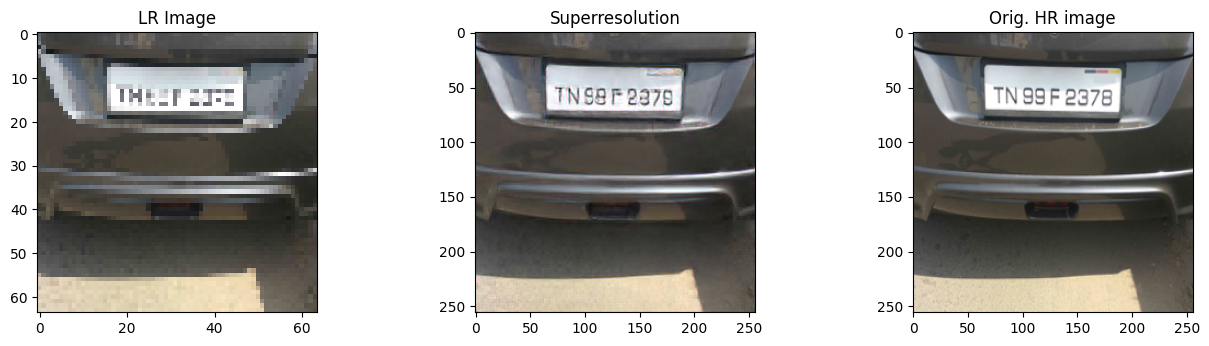

In [38]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint




[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


1/1 [==============================] - 2s 2s/step


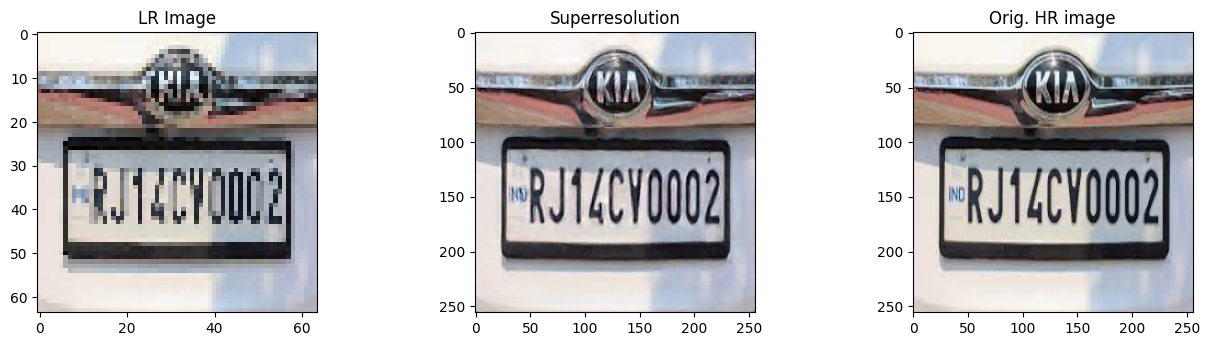

In [32]:
#for training image
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

#generator=load_model('')


[X1, X2] = [lr_train, hr_train]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


In [44]:
from PIL import Image
import os
# Replace this path with the path to your image in Google Drive
image_path = '/content/drive/MyDrive/Ml/Test_model/img_number_test.jpeg'
# Open the image using PIL
img = Image.open(image_path)
# Resize the image to 32x32
img_64 = img.resize((64, 64), Image.BICUBIC)
# Resize the image to 256*256
img_256 = img.resize((256, 256), Image.BICUBIC)
# Save the resized images to your desired location in Google Drive
output_folder = '/content/drive/MyDrive/Ml/Test_model/Resize_img/'
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)
# Save the 32x32 image
img_64.save(os.path.join(output_folder, 'img64.jpg'))
# Save the 256 image
img_256.save(os.path.join(output_folder, 'img256.jpg'))

1/1 [==============================] - 2s 2s/step


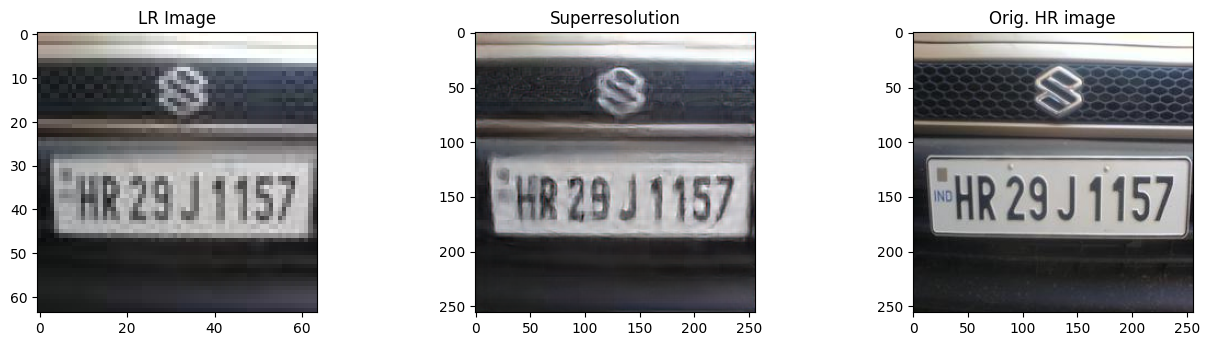

In [45]:
## CUSTOM DATA
import cv2
# Path to your LR and HR images in Google Drive
path_ip_lr = '/content/drive/MyDrive/Ml/Test_model/Resize_img/img64.jpg'
path_ip_hr = '/content/drive/MyDrive/Ml/Test_model/Resize_img/img256.jpg'
# Read the LR and HR images using OpenCV
ip_lr = cv2.imread(path_ip_lr)
ip_hr = cv2.imread(path_ip_hr)
#Change images from BGR to RGB for plotting.
#Remember that we used cv2 to load images which loads as BGR.
ip_lr = cv2.cvtColor(ip_lr, cv2.COLOR_BGR2RGB)
ip_hr = cv2.cvtColor(ip_hr, cv2.COLOR_BGR2RGB)
ip_lr = ip_lr / 255.
ip_hr = ip_hr / 255.
ip_lr = np.expand_dims(ip_lr, axis=0)
ip_hr = np.expand_dims(ip_hr, axis=0)
#PLOTTING...
generated_ip_hr = generator.predict(ip_lr)
# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(ip_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_ip_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(ip_hr[0,:,:,:])
plt.show()